### Import the dataset and using pandas_profiling for preliminary exploratory analysis

In [1]:
from pathlib import Path

import requests
import numpy as np
import pandas as pd

import pandas_profiling
from pandas_profiling.utils.cache import cache_file
#for performing sql query on pandas df
import pandasql as ps

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#Load the Kaggle cardiovascular dataset

full_data = pd.read_csv('cardio_train.csv', sep=";", index_col='id')

print(f"The cardiovascular dataset shape is {full_data.shape}");
full_data.head()

The cardiovascular dataset shape is (70000, 12)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:




    
df = pd.read_csv('cardio_train.csv', sep=";", index_col='id')


    

#I am not seen the differences with explorative=True???
profile_report = df.profile_report(explorative=True, html={'style': {'full_width': True}})
profile_report

#How to display the widget instead???
profile_report.to_widgets()

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

## Save report as html

In [5]:
profile_report.to_file("Capstone2_data_wrangling.html")

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Couple of conclusion drawed from pandas profiling results:

<b>1. There is no missing values in any of the features;<br>
2. There are abnormal values in ap_hi and ap_lo columns: in specific, the minimal value is negative, and there are extremely high entries (such as those > 10000), which apparenly are incorrect;<br>
3. ap_hi needs to be larger than ap_lo for a specific patient; <br>
4. Most binary variables are severely unbalanced, such as gender, cholesterol, gluc, smoke, alco, active. This will be handled during model training process; <br>
5. Most features are independent from each other, except that there are some correlations between height vs gender, smoke vs gender, smoke vs alco and cholesterol vs glucose; <br></b>


### Data cleaning on ap_hi and ap_lo columns

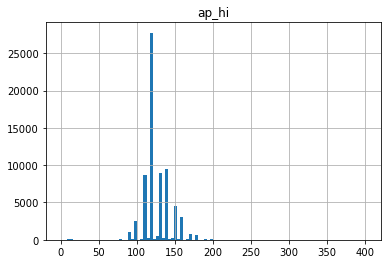

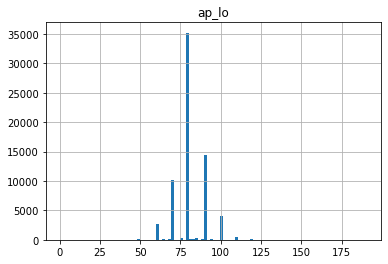

In [28]:
'''
Set maximal value as 500, minimal as 0, check histogram of ap_hi and ap_lo
'''

full_data.loc[np.logical_and(full_data.ap_hi>0, full_data.ap_hi<500)].hist(column='ap_hi', bins=100);
full_data.loc[np.logical_and(full_data.ap_lo>0, full_data.ap_lo<500)].hist(column='ap_lo', bins=100);

In [43]:
'''
Filtering criteria: ap_hi between 50-250, ap_lo between 25-150 and ap_hi>ap_lo
'''
import pandasql as ps

query = """SELECT * FROM full_data WHERE (ap_hi BETWEEN 50 AND 250) AND \
(ap_lo BETWEEN 25 AND 150) AND (ap_lo < ap_hi)"""


trimmed_data = ps.sqldf(query)

trimmed_data = trimmed_data.set_index('id')


print(f"The final trimmed data shape is {trimmed_data.shape}\n")
trimmed_data.head()

The final trimmed data shape is (68673, 12)



,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


### Double checking the trimmed data

In [44]:
trimmed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68673 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          68673 non-null  int64  
 1   gender       68673 non-null  int64  
 2   height       68673 non-null  int64  
 3   weight       68673 non-null  float64
 4   ap_hi        68673 non-null  int64  
 5   ap_lo        68673 non-null  int64  
 6   cholesterol  68673 non-null  int64  
 7   gluc         68673 non-null  int64  
 8   smoke        68673 non-null  int64  
 9   alco         68673 non-null  int64  
 10  active       68673 non-null  int64  
 11  cardio       68673 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.8 MB


In [45]:
#Some of the features, such as gender, gluc, smoke seems severely imbalnced. 
#Such caveat will be handling during the model training process
trimmed_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,68673.0,19464.528825,2468.134713,10798.0,17658.0,19701.0,21324.0,23713.0
gender,68673.0,1.348623,0.476538,1.0,1.0,1.0,2.0,2.0
height,68673.0,164.361103,8.183682,55.0,159.0,165.0,170.0,250.0
weight,68673.0,74.118744,14.331887,11.0,65.0,72.0,82.0,200.0
ap_hi,68673.0,126.668997,16.682602,60.0,120.0,120.0,140.0,240.0
ap_lo,68673.0,81.296405,9.435973,30.0,80.0,80.0,90.0,150.0
cholesterol,68673.0,1.364612,0.678859,1.0,1.0,1.0,2.0,3.0
gluc,68673.0,1.225664,0.571535,1.0,1.0,1.0,1.0,3.0
smoke,68673.0,0.087968,0.283250,0.0,0.0,0.0,0.0,1.0
alco,68673.0,0.053354,0.224741,0.0,0.0,0.0,0.0,1.0


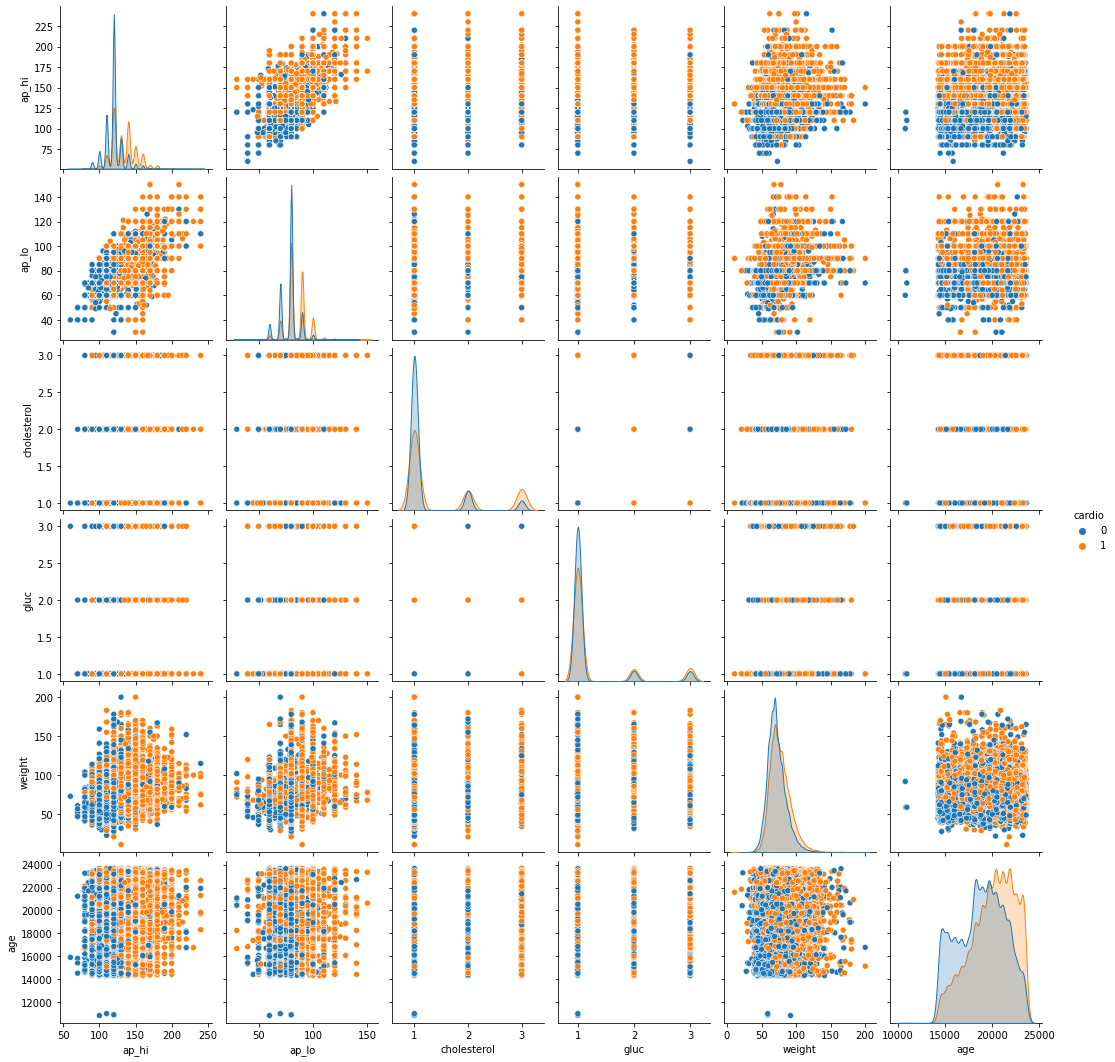

In [54]:
'''
View trimmed dataset through seaborn pairplot
Check varibles ap_hi, ap_lo, cholesterol, gluc, weight, age
'''

sns.pairplot(trimmed_data[["ap_hi", "ap_lo", "cholesterol", "gluc", "weight", "age", 'cardio']], hue='cardio')

### Based on the pairplot above, there are clear separations between healthy individuals and cardiovascular diseased patients.